“A 3-state Gaussian Hidden Markov Model was trained on options-derived and price features to classify market regimes into uptrend, downtrend, and sideways states.”

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn.hmm import GaussianHMM

pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_csv("../data/nifty_merged_features_5min.csv")
df['datetime'] = pd.to_datetime(df['datetime'])

print("Data loaded successfully ✅")
df.head()


Data loaded successfully ✅


,datetime,open,high,low,close,volume,futures_open,futures_high,futures_low,futures_close,futures_volume,open_interest,atm_strike,call_iv,put_iv,call_oi,put_oi,call_volume,put_volume,futures_basis,spot_return,futures_return,avg_iv,iv_spread,pcr_oi,pcr_volume,ema_5,ema_15
0,2024-01-01 09:20:00,21693.90,21701.05,21684.75,21696.55,0,21705.645921,21727.351567,21679.857477,21701.559036,5889,624779,21700.0,0.192032,0.195383,113462,385714,1412,3992,0.000231,0.000129,-0.000188,0.193708,-0.003351,3.399499,2.827195,21694.683333,21694.100000
1,2024-01-01 09:25:00,21697.30,21704.10,21693.20,21700.80,0,21701.559036,21736.052258,21679.857477,21714.337920,2585,602047,21700.0,0.120011,0.137796,444289,438465,2941,2152,0.000624,0.000196,0.000589,0.128904,-0.017785,0.986891,0.731724,21696.722222,21694.937500
2,2024-01-01 09:30:00,21700.15,21705.80,21684.05,21703.05,0,21714.337920,21747.814200,21692.623582,21726.088112,5659,898063,21700.0,0.150233,0.163577,385292,244903,991,3465,0.001062,0.000104,0.000541,0.156905,-0.013343,0.635630,3.496468,21698.831481,21695.951562
3,2024-01-01 09:35:00,21703.05,21711.90,21689.70,21689.70,0,21726.088112,21747.814200,21671.973884,21693.667552,3280,581472,21700.0,0.134676,0.144133,127806,206026,4101,547,0.000183,-0.000615,-0.001492,0.139405,-0.009458,1.612021,0.133382,21695.787654,21695.170117
4,2024-01-01 09:40:00,21688.00,21708.45,21685.75,21706.05,0,21693.667552,21731.730741,21671.973884,21710.020721,4749,739832,21700.0,0.129234,0.138292,311317,127965,4834,1100,0.000183,0.000754,0.000754,0.133763,-0.009058,0.411044,0.227555,21699.208436,21696.530103


In [3]:
hmm_features = [
    'avg_iv',
    'iv_spread',
    'pcr_oi',
    'futures_basis',
    'spot_return'
]

X = df[hmm_features]


In [4]:
split_index = int(0.7 * len(X))

X_train = X.iloc[:split_index]
X_test  = X.iloc[split_index:]


In [5]:
hmm = GaussianHMM(
    n_components=3,     # 3 regimes
    covariance_type="full",
    n_iter=1000,
    random_state=42
)

hmm.fit(X_train)
print("HMM model trained successfully ✅")


Model is not converging.  Current: 201102.06451694662 is not greater than 201102.14728463147. Delta is -0.08276768485666253


HMM model trained successfully ✅


In [6]:
df['regime_raw'] = hmm.predict(X)


In [7]:
regime_means = df.groupby('regime_raw')['spot_return'].mean()
print(regime_means)


regime_raw
0    0.000023
1    0.000007
2   -0.000225
Name: spot_return, dtype: float64


In [8]:
regime_map = {}

regime_map[regime_means.idxmax()] = 1     # Uptrend
regime_map[regime_means.idxmin()] = -1    # Downtrend

remaining = list(set(regime_means.index) - set(regime_map.keys()))
regime_map[remaining[0]] = 0              # Sideways

df['regime'] = df['regime_raw'].map(regime_map)


In [9]:
df['regime'].value_counts()


regime
 0    17199
 1     1103
-1      201
Name: count, dtype: int64

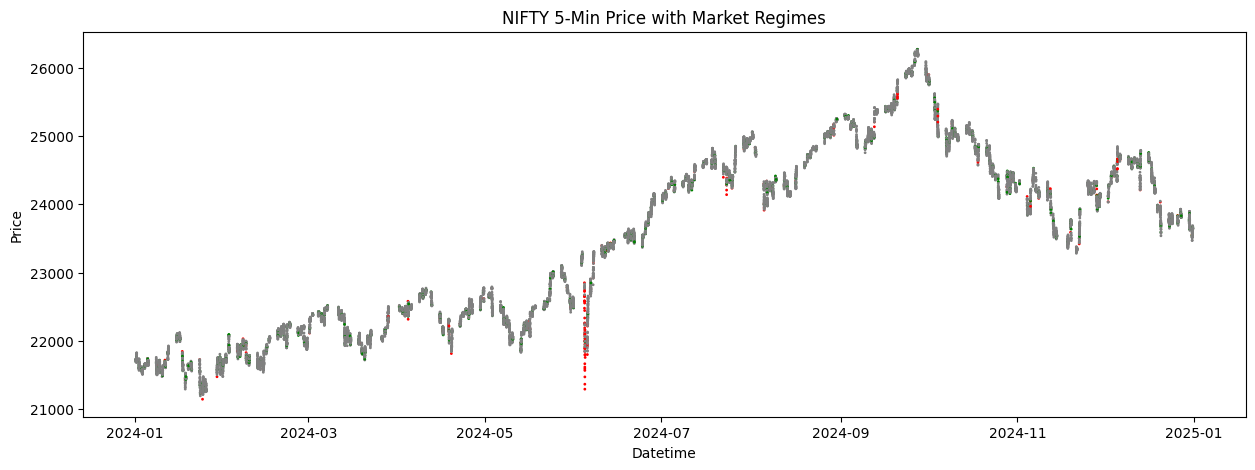

In [10]:
plt.figure(figsize=(15,5))

colors = df['regime'].map({1:'green', 0:'gray', -1:'red'})

plt.scatter(df['datetime'], df['close'], c=colors, s=1)
plt.title("NIFTY 5-Min Price with Market Regimes")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.show()


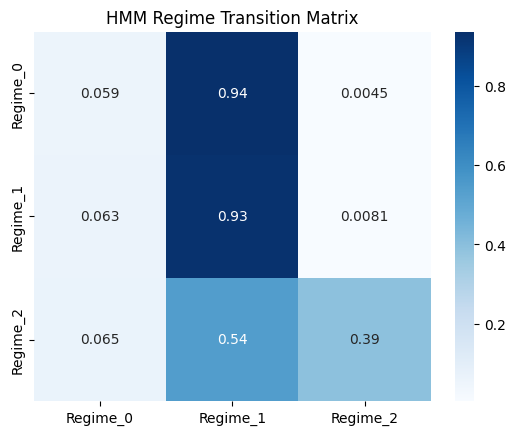

In [11]:
transition_matrix = pd.DataFrame(
    hmm.transmat_,
    columns=['Regime_0','Regime_1','Regime_2'],
    index=['Regime_0','Regime_1','Regime_2']
)

sns.heatmap(transition_matrix, annot=True, cmap="Blues")
plt.title("HMM Regime Transition Matrix")
plt.show()


In [12]:
output_file = "../data/nifty_with_regime_5min.csv"

df.to_csv(output_file, index=False)

print("Dataset with regimes saved at:", output_file)


Dataset with regimes saved at: ../data/nifty_with_regime_5min.csv
